# How to share state between threads

By default, state in a graph is scoped to that thread. But, LangGraph also allows you to specify a "scope" for a given key/value pair that exists *between* threads. For instance, you may want to store information about a user's preferences expressed in one thread, and then use that information in another thread. See this diagrams as a example, where `memories` for a specific user is shared across threads (e.g., user interactions).

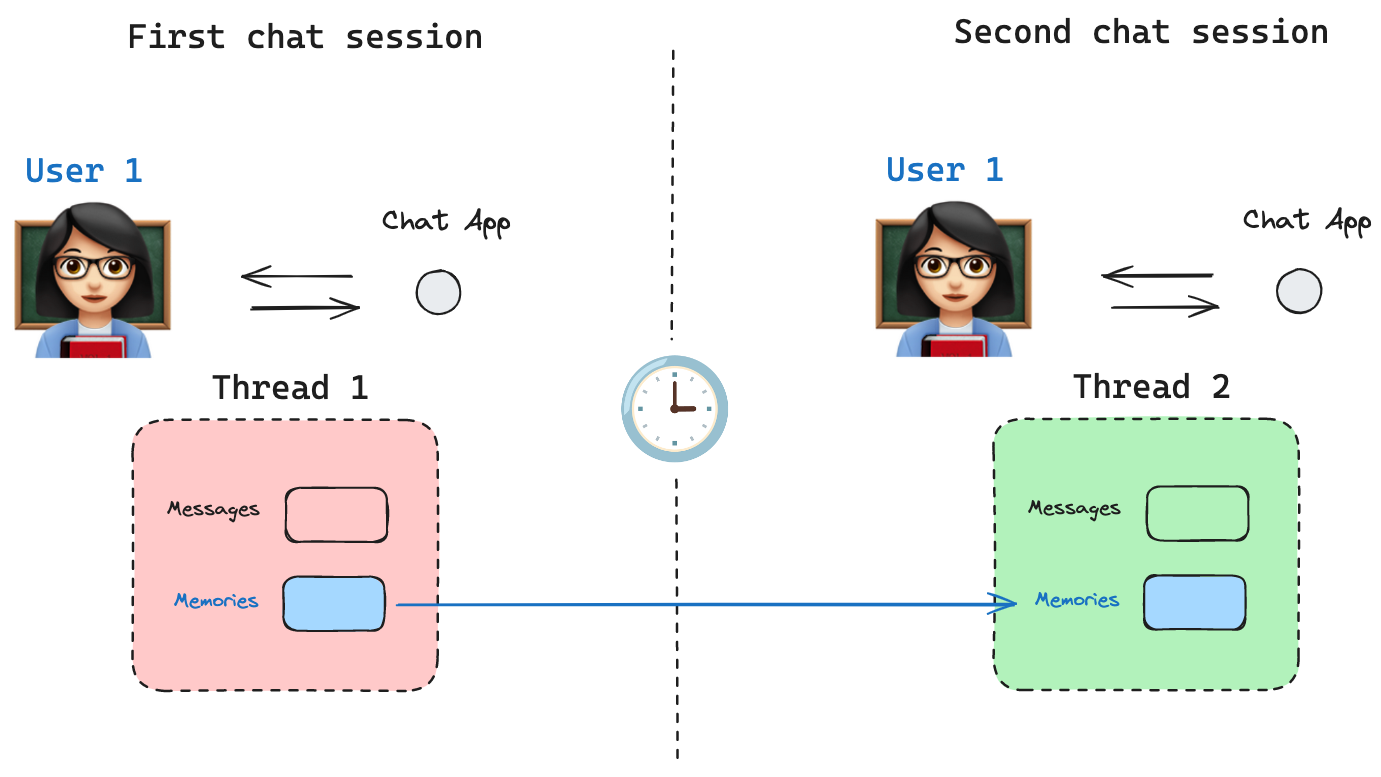

In this notebook we will go through an example of how to construct and use such a graph.

## Setup

First, let's install the required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Create graph

In this example we will create a graph that will let us store information about a user's preferences. We will do so by defining a state key that will be scoped to a user_id, and allowing the model to populate this field as it deems fit (by providing the model with a tool to save information about the user).

    
<div class="admonition note">
    <p class="admonition-title">Typing shared state keys</p>
    <p style="margin-top: 5px;">
        Shared state channels (keys) MUST be dictionaries (see <code>info</code> channel in the AgentState example below)
    </p>
</div>

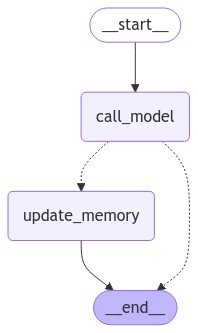

In [2]:
from IPython.display import Image, display

from langgraph.graph.graph import START, END
from langgraph.graph.message import MessagesState
from langgraph.graph.state import StateGraph
from langgraph.store.memory import MemoryStore
from langgraph.managed.shared_value import SharedValue
from typing import TypedDict, Annotated, Any
import uuid
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver


class AgentState(MessagesState):
    # We use an info key to track information
    # This is scoped to a user_id, so it will be information specific to each user
    info: Annotated[dict, SharedValue.on("user_id")]


# We will give this as a tool to the agent
# This will let the agent call this tool to save a fact
class Info(TypedDict):
    """This tool should be called when you want to save a new fact about the user.
    
    Attributes:
        fact (str): A fact about the user.
        topic (str): The topic related the fact is about, i.e. Food, Location, Movies, etc.
    """
    fact: str
    topic: str


# This is the prompt we give the agent
# We will pass known info into the prompt
# We will tell it to use the Info tool to save more
prompt = """You are helpful assistant.

Here is what you know about the user:

<info>
{info}
</info>

Help out the user. If the user tells you any information about themselves, save the information using the `Info` tool.

This means if the user provides any sort of fact about themselves, be it an opinion they have, a fact about themselves, etc. SAVE IT!
"""


# We give the model access to the Info tool
model = ChatOpenAI().bind_tools([Info])


# Our first node - this will call the model
def call_model(state):
    # We get all facts and assemble them into a string
    facts = [d['fact'] for d in state['info'].values()]
    info = "\n".join(facts)
    # Format system prompt
    system_msg = prompt.format(info=info)
    # Call model
    response = model.invoke([{"role": "system", "content": system_msg}] + state['messages'])
    return {"messages": [response]}


# Routing function to decide what to do next
# If no tool calls, then we end
# If tool calls, then we update memory
def route(state):
    if len(state['messages'][-1].tool_calls) == 0:
        return END
    else:
        return "update_memory"


# This function is responsible for updating the memory
def update_memory(state):
    tool_calls = []
    memories = {}
    # Each tool call is a new memory to save
    for tc in state['messages'][-1].tool_calls:
        # We append ToolMessages (to pass back to the LLM)
        # This is needed because OpenAI requires each tool call be followed by a ToolMessage
        tool_calls.append({"role": "tool", "content": "Saved!", "tool_call_id": tc['id']})
        # We create a new memory from this tool call
        memories[str(uuid.uuid4())] = {"fact": tc['args']['fact'], "topic": tc['args']['topic']}
    # Return the messages and memories to update the state with
    return {"messages": tool_calls, "info": memories}


# This is the in memory checkpointer we will use
# We need this because we want to enable threads (conversations)
memory = MemorySaver()

# This is the in memory Key Value store
# This is needed to save the memories
kv = MemoryStore()

# Construct this relatively simple graph
graph = StateGraph(AgentState)
graph.add_node(call_model)
graph.add_node(update_memory)
graph.add_edge("update_memory", END)
graph.add_edge(START, "call_model")
graph.add_conditional_edges("call_model", route)
graph = graph.compile(checkpointer=memory, store=kv)
# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Run graph on one thread

We can now run the graph on one thread and give it some information. 

We can see that the `Info` tool is called in the second two cases when we supply specific information about the user.

The `Info` tool writes to the `info` key in the `AgentState`. 

This key is scoped to the `user_id`.

In [3]:
from pprint import pprint
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# First let's just say hi to the AI
for event in graph.stream({"messages": [HumanMessage(content="hi")]}, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

hi
================================== Ai Message ==================================

Hello! How can I assist you today?


In [4]:
# Let's continue the conversation (by passing the same config) and tell the AI we like pepperoni pizza
for event in graph.stream({"messages": [HumanMessage(content="i like pepperoni pizza")]}, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

i like pepperoni pizza
================================== Ai Message ==================================
Tool Calls:
  Info (call_lTp2Zah9pAtKCI1OcGTTKXtP)
 Call ID: call_lTp2Zah9pAtKCI1OcGTTKXtP
  Args:
    fact: I like pepperoni pizza
    topic: Food
================================= Tool Message =================================

Saved!


In [5]:
# Let's continue the conversation even further (by passing the same config) and tell the AI we live in SF
for event in graph.stream({"messages": [HumanMessage(content="i also just moved to SF")]}, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

i also just moved to SF
================================== Ai Message ==================================
Tool Calls:
  Info (call_BNxabn25WuvZA3PCpykGZLHm)
 Call ID: call_BNxabn25WuvZA3PCpykGZLHm
  Args:
    fact: I just moved to SF
    topic: Location
================================= Tool Message =================================

Saved!


## Run graph on a different thread

We can now run the graph on a *different thread*, but the *same user*. 

The `info` key is scoped to the `user_id`, so we can see that it remembers facts about the user (specifically that the user likes pepperoni pizza and lives in SF). 

In [6]:
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

for event in graph.stream({"messages": [HumanMessage(content="where and what should I eat for dinner? can you list some restaurants?")]}, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

where and what should I eat for dinner? can you list some restaurants?
================================== Ai Message ==================================

Sure! I can suggest some restaurants for you to try out in San Francisco. Here are a few options:

1. Tony's Pizza Napoletana - Known for their delicious pizza, including pepperoni pizza.
2. House of Prime Rib - A popular spot for a classic prime rib dinner.
3. The Slanted Door - Offers modern Vietnamese cuisine with a beautiful view of the Bay Bridge.
4. Tadich Grill - San Francisco's oldest continuously operating restaurant, known for seafood and steaks.
5. La Taqueria - Famous for their authentic Mexican tacos.

Do any of these options sound appealing to you? Let me know if you'd like more recommendations or information about any specific restaurant.


Perfect! The AI recommended restaurants in SF, and included a pizza restaurant at the top of it's list.

Notice that the `messages` in this new thread do NOT contain the messages from the previous thread since we didn't store them as shared values across the `user_id`. However, the `info` we saved in the previous thread was saved since we passed in the same `user_id` in this new thread.

Let's now run the graph for another user to verify that the preferences of the first user are self contained:

In [7]:
config = {"configurable": {"thread_id": "3", "user_id": "2"}}

for event in graph.stream({"messages": [HumanMessage(content="where and what should I eat for dinner? can you list some restaurants?")]}, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

where and what should I eat for dinner? can you list some restaurants?
================================== Ai Message ==================================

I can suggest some restaurants based on your location and preferences. Could you please provide me with your location or any specific cuisine you are in the mood for?


Perfect! The graph has forgotten all of the previous preferences and has to ask the user for it's location and dietary preferences.